## Data Analysis

###**Part 0: Set- up & Preliminary Checks**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# for logistic regression and for kfold
from statsmodels.formula.api import logit
from sklearn.model_selection import KFold

# for creating confusion matrix
from sklearn.metrics import confusion_matrix

In [2]:
#import dataset
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1cN2Ah5fvJoYyYHg8zVhN_JhCVOHaiRrb')
df.head()

,Lars2,Malat1,mature
0,9.95,6.69,1
1,10.54,8.53,1
2,6.58,8.74,1
3,7.49,9.09,1
4,7.42,9.87,1


###**Part A: Confusion Matrix**

In [3]:
# Multinomial logistic regression model
bothmdl = logit(formula = "mature ~ Lars2 + Malat1 + 1", data = df).fit()
print(bothmdl.summary())

Optimization terminated successfully.
         Current function value: 0.196827
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 mature   No. Observations:                  817
Model:                          Logit   Df Residuals:                      814
Method:                           MLE   Df Model:                            2
Date:                Mon, 14 Aug 2023   Pseudo R-squ.:                  0.6088
Time:                        03:26:02   Log-Likelihood:                -160.81
converged:                       True   LL-Null:                       -411.04
Covariance Type:            nonrobust   LLR p-value:                2.122e-109
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -25.5697      2.177    -11.743      0.000     -29.838     -21.302
Lars2          2.3119      0.

In [4]:
ypred2 = np.where(bothmdl.predict(df[['Lars2', 'Malat1']]) > 0.5,1,0)
c_matrix = pd.crosstab(df.mature, ypred2, rownames=['Actual'], colnames=['Predicted'])
c_matrix

Predicted,0,1
Actual,,
0,618,34
1,45,120


In [5]:
# Calculate the fractions
fraction_correctly_classified_mature = c_matrix.loc[1, 1] / c_matrix.loc[1].sum()
fraction_correctly_classified_immature = c_matrix.loc[0, 0] / c_matrix.loc[0].sum()
fraction_correctly_classified_all = (c_matrix.loc[1, 1] + c_matrix.loc[0, 0]) / c_matrix.values.sum()

print("Fraction of correctly classified mature cells:", fraction_correctly_classified_mature)
print("Fraction of correctly classified immature cells:", fraction_correctly_classified_immature)
print("Fraction of correctly classified all cells:", fraction_correctly_classified_all)

Fraction of correctly classified mature cells: 0.7272727272727273
Fraction of correctly classified immature cells: 0.9478527607361963
Fraction of correctly classified all cells: 0.9033047735618115


###**Part B: Assessing Accuracy**

**Given the current distribution of the two classes within the dataset (80% immature, 20% mature), the accuracy of a naive model that only predicts (immature=0) would be 80% across all data points. The accuracy of a naive model that  only predicts (mature=1) would be 20% across all data points**

###**Part C: False Positive Plot**

Our classifier used a Bayesian criterion, P(mature | Malat1, Lars2) > Threshold, where the threshold was set at Threshold = 0.5. We will make a plot showing the false positive rate as a function of Threshold in order to analyze how different threshold values achieve a particular false positive rate.


In [8]:
# Create an array of threshold values
thresholds = np.linspace(0, 1, num=101)

# Initialize lists to store metrics
fprs = []
tprs = []
precisions = []
recalls = []
f1s = []

# Loop through each threshold value
for threshold in thresholds:
    # Predict labels using the current threshold value
    predicted_labels = np.where(bothmdl.predict(df[['Lars2', 'Malat1']]) > threshold, 1, 0)

    # Calculate confusion matrix values
    tn, fp, fn, tp = confusion_matrix(df.mature, predicted_labels).ravel()

    # Calculate false positive rate (fpr)
    fpr = fp / (fp + tn)
    fprs.append(fpr)

    # Calculate true positive rate (tpr)
    tpr = tp / (tp + fn)
    tprs.append(tpr)

    # Calculate precision, recall, and F1 score
    precision = tp / (tp + fp)
    precisions.append(precision)
    recall = tp / (tp + fn)
    recalls.append(recall)
    f1 = (2 * precision * recall) / (precision + recall)
    f1s.append(f1)

<ipython-input-8-2a85dd86d4dd>:28: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


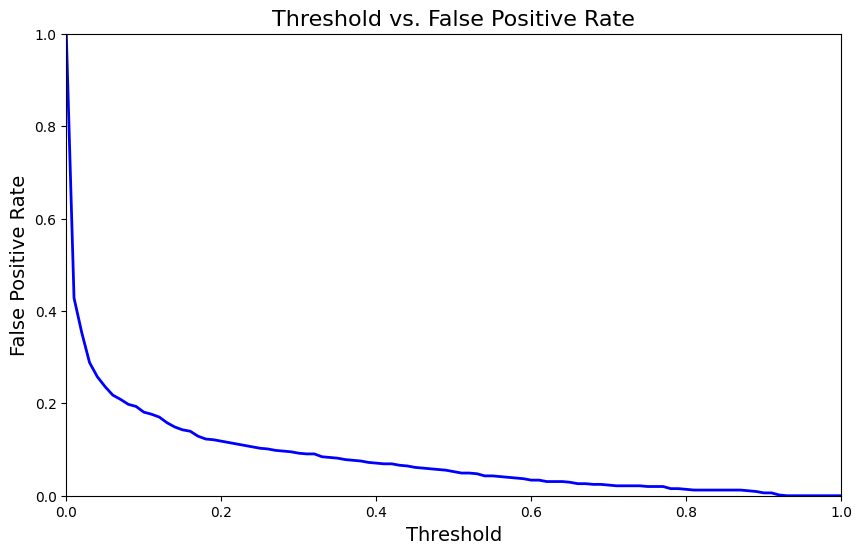

In [19]:
# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(thresholds, fprs, color='blue', linewidth=2, label='False Positive Rate')

ax.set_xlabel('Threshold', fontsize=14)
ax.set_ylabel('False Positive Rate', fontsize=14)
ax.set_title('Threshold vs. False Positive Rate', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.show()

###**Part D: Classifier as a Function of Threshold**

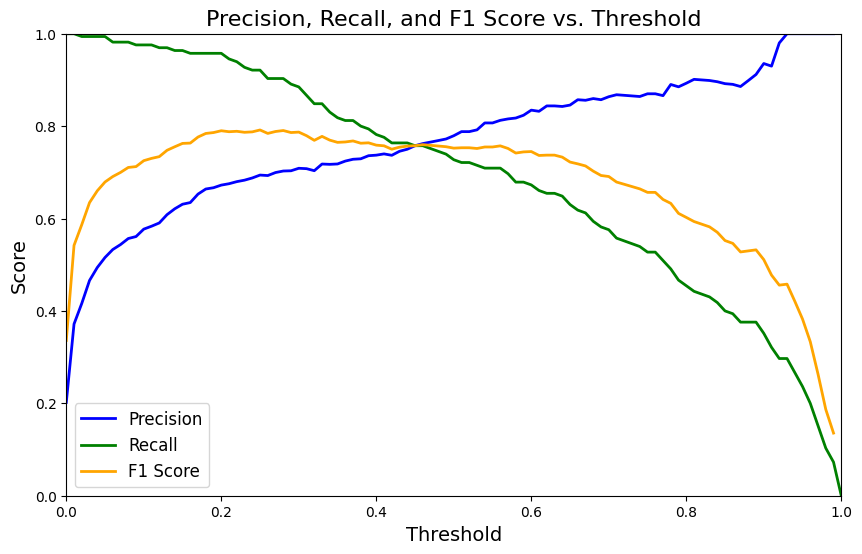

In [21]:
# Plotting precision, recall, and F1 of the classifier as a function of Threshold

fig, ax = plt.subplots(figsize=(10, 6))

# precision, recall, and F1
ax.plot(thresholds, precisions, color='blue', linewidth=2, label='Precision')
ax.plot(thresholds, recalls, color='green', linewidth=2, label='Recall')
ax.plot(thresholds, f1s, color='orange', linewidth=2, label='F1 Score')

# Set labels and title
ax.set_xlabel('Threshold', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Precision, Recall, and F1 Score vs. Threshold', fontsize=16)

# Add legend in the best location
ax.legend(loc='best', fontsize=12)

# Set axis limits
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.show()

###**Part E: ROC Plot**

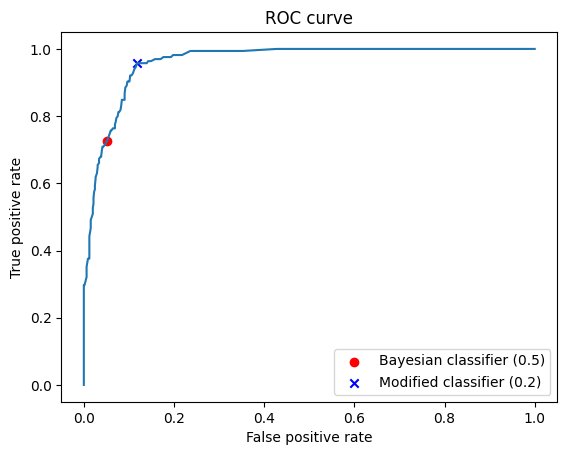

In [22]:
# Make a ROC plot, i.e. show the true positive rate vs. the false positive rate for all Threshold values
fig, ax = plt.subplots()
ax.plot(fprs, tprs)

# mark Bayesian classifier point
bayes_fpr = fprs[50]
bayes_tpr = tprs[50]
plt.scatter(bayes_fpr, bayes_tpr, color='red', marker='o', label='Bayesian classifier (0.5)')

# mark modified classifier point
mod_fpr = fprs[20]
mod_tpr = tprs[20]
plt.scatter(mod_fpr, mod_tpr, color='blue', marker='x', label='Modified classifier (0.2)')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()


###**Part F: Discussion**

**It's clear from the plot above that meeting the criteria of a false positive rate of 10% or less and a true positive rate of 95% or higher is not possible. The plot doesn't show any point that fulfills these requirements.**

# Cross-validation and Bootstrap Resampling

Now, we will use cross-validation and bootstrap resampling to estimate the reliability of our classifier. We will continue using the same classifier, with threshold = 0.5.

###**Part A**

In [ ]:
k = 10

# Initialize two arrays to store the training and testing error.
trainErr = []
testErr = []

kf = KFold(n_splits = k, random_state = 109, shuffle = True)

for trlInd, testInd in kf.split(df):
    # For each it. select len/k index & save the rest to train.
    testdf = df.iloc[testInd,]
    traindf = df.iloc[trlInd,]

    # Fit model.
    mdl = logit(formula = "mature ~ Malat1 + Lars2 + 1", data = traindf).fit(disp = False)

    trainPred = mdl.predict(traindf)
    testPred = mdl.predict(testdf)

    # Total error rate for both the training and test sets.
    trainErr.append(sum((trainPred > 0.5) != traindf['mature']) / len(traindf))
    testErr.append(sum((testPred > 0.5) != testdf['mature']) / len(testdf))

print('Total error rate for training set:', trainErr)
print('Total error rate for testing set:', testErr)

Total error rate for training set: [0.09659863945578231, 0.09115646258503401, 0.09659863945578231, 0.09659863945578231, 0.08979591836734693, 0.09659863945578231, 0.09931972789115646, 0.09510869565217392, 0.09782608695652174, 0.09375]
Total error rate for testing set: [0.0975609756097561, 0.13414634146341464, 0.08536585365853659, 0.07317073170731707, 0.14634146341463414, 0.08536585365853659, 0.06097560975609756, 0.12345679012345678, 0.08641975308641975, 0.1111111111111111]


In [ ]:
# Table showing the training and test error for each of the folds
error_table = pd.DataFrame({'Training Error': trainErr, 'Testing Error': testErr})
print(error_table)

   Training Error  Testing Error
0        0.096599       0.097561
1        0.091156       0.134146
2        0.096599       0.085366
3        0.096599       0.073171
4        0.089796       0.146341
5        0.096599       0.085366
6        0.099320       0.060976
7        0.095109       0.123457
8        0.097826       0.086420
9        0.093750       0.111111


###**Part B**

In [ ]:
# Mean training error, averaged over the 10 folds
a = np.array(trainErr)
np.mean(a)

0.09533514492753623

In [ ]:
# Standard error of the mean (SEM) for the training
np.std(a)/ math.sqrt(10)

0.0008898075522135252

In [ ]:
# Mean testing error, averaged over the 10 folds
b = np.array(testErr)
np.mean(b)

0.10039144835892803

In [ ]:
# Standard error of the mean (SEM) for the testing set
np.std(b)/ math.sqrt(10)

0.008274690590659061

**The mean training error is slightly lower than the mean test error, indicating that the model is overfitting slightly. However, the difference between the mean training and test errors is not very large, which suggests that the model is not overfitting too much. The SEM of the training error is smaller than the SEM of the test error, which indicates that the training error is more precise than the test error.**

###**Part C**

In [ ]:
boots = 100

# Initialize an empty array of length 100 to store the estimated coefficient result.
fitParamArr = np.zeros(boots)

for i in range(boots):
    # Sample with replacement
    thisBoot = df.sample(frac=1, replace=True)

    # Fit model
    mdl = logit(formula = "mature ~ Malat1 + Lars2 + 1", data = thisBoot).fit(disp = False)

    # Put the estimated param back to the array, to eventually create a distribution
    fitParamArr[i] = mdl.params.loc['Malat1']

In [ ]:
fitParamArr.mean()

1.107922553876709

In [ ]:
fitParamArr.std()

0.14541766377362808

###**Part D**

In [ ]:
# 95% confidence interval for the coefficient Malat1.

upper = fitParamArr.mean() + (1.96 * fitParamArr.std()/math.sqrt(10))
lower = fitParamArr.mean() - (1.96 * fitParamArr.std()/math.sqrt(10))

print(f"95% confidence interval for coefficient Malat1: ({lower}, {upper})")

95% confidence interval for coefficient Malat1: (1.0177917520858457, 1.1980533556675723)
